# YOLO for Object Tracking
## Tracking Traffic Signs and Traffic Lights


### Dataset
First and foremost, it is essential to download the dataset that will be used for training the YOLOv8 architecture. Additionally, we will download a series of videos from another dataset to check and test whether our architecture functions correctly.

In [ ]:
import kagglehub
dataset_path_origin = kagglehub.dataset_download('pkdarabi/cardetection')
traffic_lights_video_path = kagglehub.dataset_download('matteoiorio/traffic-lights-video')

#### COLAB Utility
Add utility function for avoiding the colab disconnection during the YOLO training of the network. This function click every 60000 milliseconds to the connect button, in this way we can avoid to be disconnecte.

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

Set the correct path for the dataset, in this way we can directly access the entire dataset using the following path.


In [ ]:
dataset_path = dataset_path_origin + "/car"
print(dataset_path)

/root/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/car


## YOLO
Now that both datasets have been imported, it's essential to install the YOLO library to achieve our goal. The YOLO network is highly efficient for object detection tasks. However, we will also need to incorporate other computer vision algorithms to adapt object detection for object tracking.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.1/903.1 kB 51.1 MB/s eta 0:00:00


### Dependencies
Before starting with this notebook, It is necessary to import all the different dependencies that will be used for training the network and use the trained network for tracking the different traffic signs and traffic lights.

In [ ]:
# Import Essential Libraries
import os
import random
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from IPython.display import HTML
from base64 import b64encode
import yaml
import glob
from tqdm.notebook import trange, tqdm
from ipywidgets import interact, fixed, Dropdown
import warnings
warnings.filterwarnings('ignore')

### Dataset
For this project, we utilized a labeled traffic sign dataset containing 4,969 samples, we managed
to find the dataset by using the Roboflow Universe community. The Roboflow Universe is the largest collection of open source computer vision datasets and APIs. The dataset was well-structured and divided into three subsets:
1. Train
2. Test
3. Validation
The dataset includes 15 traffic sign classes, covering both traffic lights and speed limit signs:
1. Traffic Lights: Green Light, Red Light
2. Speed Limits: Speed Limit 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120
3. Stop Sign: Stop

To prepare the dataset for training, the images were preprocessed and stored following the structure required by the YOLOv8 framework. The data.yaml configuration file defined the class names and paths to the training, validation, and test datasets.

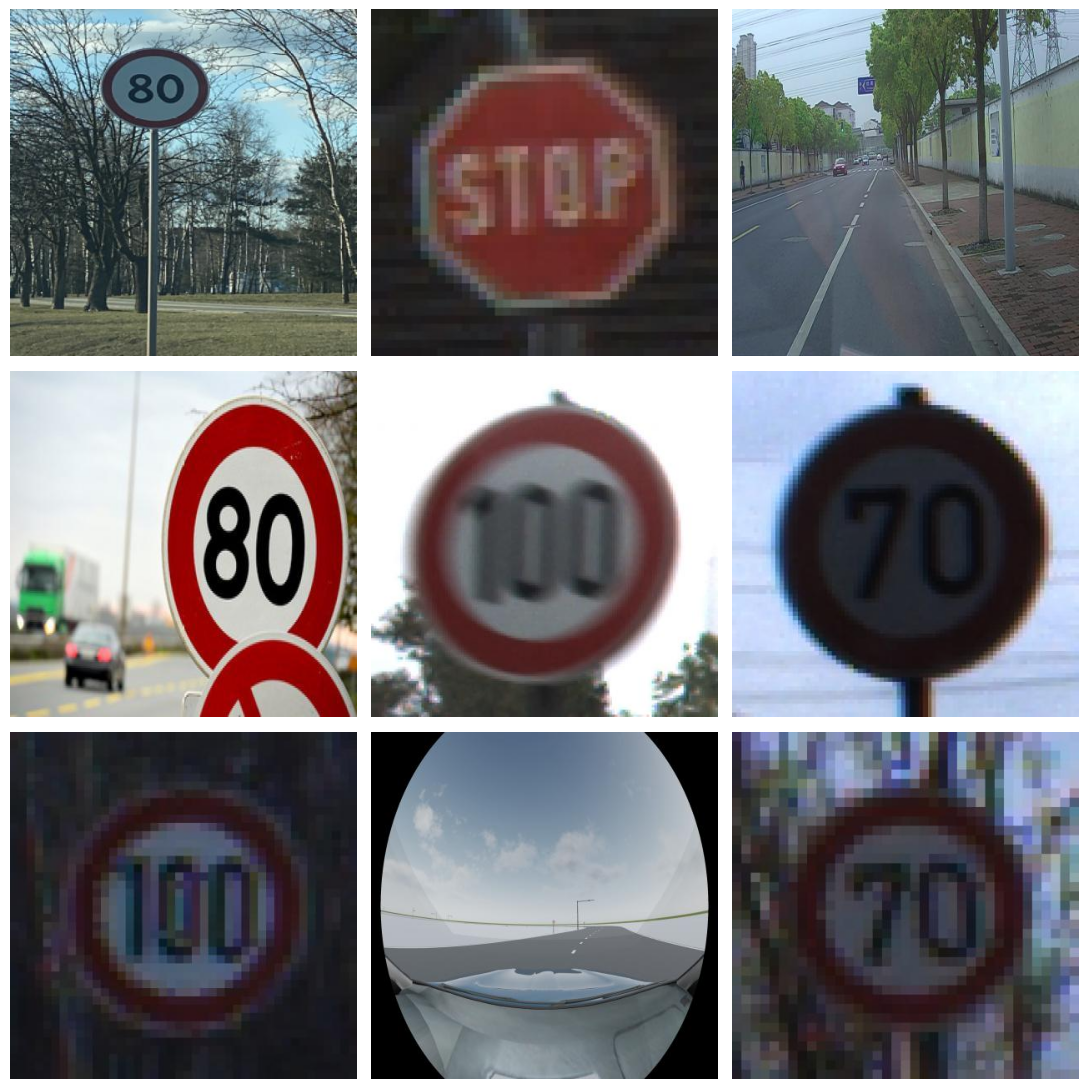

In [ ]:
Image_dir = dataset_path + "/train/images"

num_samples = 9
image_files = os.listdir(Image_dir)

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.axis('off')

plt.tight_layout()
plt.show()

### YOLOv8 import and training
We trained the YOLOv8 model using the pre-trained weights (yolov8n.pt) provided by the Ultralytics library. Training was conducted for 30 epochs with an automatic batch size and Adam as optimizer.

In [11]:
final_model = YOLO('yolov8n.pt')
output_data_path = dataset_path + "/data.yaml"
results = final_model.train(data=output_data_path,epochs = 30, batch = -1, optimizer = 'auto', augment=True)

NameError: name 'dataset_path' is not defined

### Export of the model
Export the model for futher uses, in this way we do not need to train again the network but we can use the already trained network.

In [ ]:
final_model.export(format='onnx')

### Import the videos
By using the traffic lights dataset we can export some videos, where It would be possible to test our model and see If It can detect with high accuracy the different traffic signs and traffic lights.

In [ ]:
print(os.listdir(traffic_lights_video_path))
trained_model = YOLO('runs/detect/train/weights/best.pt')

['traffic_lights_red_1.mp4', 'yolo_best_traffic.pt', 'traffic_lights_1.mp4', 'traffic_lights_2.mp4', 'traffic_light_3.mp4', 'road_video_1.mp4']


### Error handling
Set UTF-8 as encoding for possible errors

In [ ]:
import locale

print(locale.getpreferredencoding())
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

UTF-8


### Object Traking Phase
#### Intersection over Union
Intersection over Union (IoU) is a metric used to evaluate the accuracy of object detection and tracking systems. It measures the overlap between two bounding boxes:

1. The predicted bounding box (what the model detects).
2. The ground truth bounding box (the actual or correct bounding box).

Mathematically, it is defined as:
$$ IoU = \frac{\text{Area of Overlap}}{\text{Area of Union}} $$
Where:

1. **Area of Overlap** is the region where the predicted and ground truth boxes intersect.
2. **Area of Union** is the total area covered by both bounding boxes combined, subtracting any overlap to avoid double-counting.

IoU serves as a quantitative measure of how well the predicted bounding box aligns with the ground truth. It ranges between 0 and 1:

1. IoU = 0 means no overlap between the boxes.
2. IoU = 1 means perfect overlap.

When tracking an object across frames, IoU helps in determining whether the object detected in the current frame corresponds to the same object detected in the previous frame.


In [ ]:
def compute_iou(bb1, bb2):
  bb1_x1=bb1[0]
  bb1_y1=bb1[1]
  bb1_x2=bb1[2]
  bb1_y2=bb1[3]

  bb2_x1=bb2[0]
  bb2_y1=bb2[1]
  bb2_x2=bb2[2]
  bb2_y2=bb2[3]

  x_left = max(bb1_x1, bb2_x1)
  y_top = max(bb1_y1, bb2_y1)
  x_right = min(bb1_x2, bb2_x2)
  y_bottom = min(bb1_y2, bb2_y2)

  if x_right < x_left or y_bottom < y_top:
    return 0.0

  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  bb1_area = (bb1_x2 - bb1_x1) * (bb1_y2 - bb1_y1)
  bb2_area = (bb2_x2 - bb2_x1) * (bb2_y2 - bb2_y1)

  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

### Bounding Box tracker
The IOUTracker class is designed for simple object tracking in video or image sequences using Intersection-over-Union (IoU) as the basis for associating detected objects between frames. This tracker maintains a set of tracked objects and updates their positions based on new detections in each frame.
#### Initialization:
1. **\_\_init\_\_**(iou_threshold=0.5): Initializes the tracker with the following attributes:
iou_threshold: A float specifying the minimum IoU required to consider two bounding boxes as the same object (default is 0.5).
2. tracked_objects: A dictionary mapping object IDs to their bounding boxes.
next_object_id: An integer counter for assigning unique IDs to new objects.

#### Methods

1. **update**(detections): Updates the set of tracked objects based on new detections.
  * **Parameters**: *detections*: A list of bounding boxes in the format [[x1, y1, x2, y2], ...], where (x1, y1) is the top-left corner, and (x2, y2) is the bottom-right corner of the bounding box.

#### Process:
For each existing tracked object, it calculates the IoU with each detection.
Matches the detection with the highest IoU above the iou_threshold to the tracked object. Any unmatched detections are considered new objects and are assigned unique IDs. Returns:
* An updated dictionary of tracked objects (object_id -> bounding_box).

#### Key Features

* Tracks objects over multiple frames by associating new detections to existing tracked objects using IoU.
* Dynamically assigns new IDs to previously unseen objects.
* Provides a straightforward and efficient tracking mechanism, suitable for scenarios with moderate object movement and consistent detections.

In [ ]:
class IOUTracker:
    def __init__(self, iou_threshold=0.5):
        self.iou_threshold = iou_threshold
        self.tracked_objects = {}  # Object ID -> Bounding Box
        self.next_object_id = 0

    def update(self, detections):
        """
        Update tracked objects based on new detections.
        detections: List of bounding boxes [[x1, y1, x2, y2], ...].
        """
        updated_tracked_objects = {}
        assigned_detections = set()
        # Match existing tracked objects to new detections
        for obj_id, prev_bbox in self.tracked_objects.items():
            best_iou = 0
            best_det_idx = -1

            for idx, det_bbox in enumerate(detections):
                if idx in assigned_detections:
                    continue
                iou = compute_iou(prev_bbox, det_bbox)
                if iou > best_iou and iou >= self.iou_threshold:
                    best_iou = iou
                    best_det_idx = idx

            if best_det_idx != -1:
                updated_tracked_objects[obj_id] = detections[best_det_idx]
                assigned_detections.add(best_det_idx)

        # Add new detections as new objects
        for idx, det_bbox in enumerate(detections):
            if idx not in assigned_detections:
                updated_tracked_objects[self.next_object_id] = det_bbox
                self.next_object_id += 1

        self.tracked_objects = updated_tracked_objects
        return self.tracked_objects


### Create the new video
The create_new_video function processes a given video to detect and track objects using a YOLO model and an Intersection-over-Union (IoU)-based tracker. The function outputs a new video with bounding boxes and object IDs annotated for each detected object.

#### Parameters

1. **video_name**: A string representing the name of the input video file to be processed. The file is expected to be located in the directory specified by traffic_lights_video_path.

#### Process

Set Up Paths and Video Properties:
1. Constructs the input video path by combining traffic_lights_video_path with video_name.
2. Defines the output video name by appending -output.mp4 to the base name of the input video.
3. Reads the input video using OpenCV (cv2.VideoCapture) and extracts properties like frame rate (fps), width, and height.

#### Initialize Tracker and Writer:
1. Sets up a video writer (cv2.VideoWriter) to save the processed video.
2. Initializes an IOUTracker with a default IoU threshold of 0.5.

#### Process Video Frames:
Reads each frame of the video.
1. Performs object detection using a YOLO model (trained_model.predict).
2.Extracts bounding boxes ([x1, y1, x2, y2]) from YOLO predictions.

#### Object Tracking:
Updates tracked objects by passing detected bounding boxes to the IOUTracker.
Annotates the frame with bounding boxes and corresponding object IDs using cv2 rectangle and cv2.putText.

#### Save Output:
Writes each annotated frame to the output video file.

#### Cleanup:
Releases the video capture and writer objects.

####Returns
* output_video_path: A string representing the file path of the processed output video.

In [ ]:
def create_new_video(video_name: str):
  input_path = traffic_lights_video_path + "/" + video_name
  print(input_path)
  output_video_path = video_name.split('.')[0] + "-output.mp4"
  cap = cv2.VideoCapture(input_path)

  # Get video properties
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Set up video writer
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
  tracker = IOUTracker(iou_threshold=0.5)

  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break
      # Perform YOLO inference
      results = trained_model.predict(frame, verbose=False, conf=0.5)
      detections = results[0].boxes.data.cpu().numpy()  # [x1, y1, x2, y2, conf, class]
      # Extract bounding boxes from detections
      bbox_list = []
      for det in detections:
          x1, y1, x2, y2, conf, cls = det
          bbox_list.append([x1, y1, x2, y2])

      # Update tracker
      tracked_objects = tracker.update(bbox_list)

      # Draw tracked objects
      for obj_id, bbox in tracked_objects.items():
          x1, y1, x2, y2 = map(int, bbox)
          cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
          cv2.putText(frame, f'ID: {trained_model.names[cls]}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

      # Save the processed frame
      out.write(frame)

  cap.release()
  out.release()
  return output_video_path

### Test a video
Now that It was possible to train our system we can test the YOLO architecture on a video, by using the create\_new\_video function, then after parsing the video and checking If in each frame there is an possible object we create the output video that is possible to visualize by the following cell.

In [ ]:
  video = create_new_video("road_video_1.mp4")
  print(video)
  mp4 = open(video,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  HTML(""" <video controls><source src="%s" type="video/mp4"></video>""" % data_url)

/root/.cache/kagglehub/datasets/matteoiorio/traffic-lights-video/versions/5/road_video_1.mp4
road_video_1-output.mp4
